In [3]:
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler 

In [180]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_excel('DS_ML Coding Challenge Dataset.xlsx', engine='openpyxl', sheet_name=1)

## Index:
1. Problem definition
2. EDA
3. Preprocessing and Feature Engineering
4. Selecting performance metric
5. Modelling

# 1. Problem definition

- Every row represents the sourcing of one unit of a particular product combination.
- A unique product combination comprises of attributes mentioned in Columns A,B,C,D,E,F
- Since each row represents 1 unit of sourcing, therefore, there are multiple rows with the same combination in the training dataset. Imagine buying 1 quantity being represented as a single row.
- July 2020 to May 2021 is the training set and June 2021 is the test set. So using the 11 months data (Training Set: June 2020 to May 2021) the forecast/predict the June 2021 number (Test Set) has to be made
- June 2021 has only a single value for each combination as that is the test set (target).

# 2. EDA

## 2.1 Non visual analysis

In [5]:
df.shape

(550176, 8)

There are 550k unique entries in the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550176 entries, 0 to 550175
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ProductType        550176 non-null  object        
 1   Manufacturer       550176 non-null  object        
 2   Area Code          550176 non-null  object        
 3   Sourcing Channel   550176 non-null  object        
 4   Product Size       550176 non-null  object        
 5   Product Type       550176 non-null  object        
 6   Month of Sourcing  550176 non-null  datetime64[ns]
 7   Sourcing Cost      550176 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 33.6+ MB


### There are no null values

In [7]:
df.duplicated().sum()

541165

There are large number of duplicate rows since each row denotes one unique purchase, we've to group these accordingly

In [8]:
df['index']=df.index

In [9]:
dfg = df.groupby(
    [
        'ProductType',	'Manufacturer',	'Area Code', 'Sourcing Channel',
        'Product Size',	'Product Type',	'Month of Sourcing', 'Sourcing Cost'
    ]
).agg({'index':'count'}).reset_index().rename(columns={'index' : 'num_units'})

In [10]:
dfg.shape

(9011, 9)

In [11]:
dfg.head(10)

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,num_units
0,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,82.428,46
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,89.489,104
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,95.089,116
3,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,100.372,87
4,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,104.454,66
5,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,106.427,190
6,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,109.735,89
7,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,111.520,34
8,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,113.444,79
9,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,113.636,91


Still, there are multiple products bought for different prices in the same month

In [12]:
dfg.nunique()

ProductType             3
Manufacturer            3
Area Code              45
Sourcing Channel        4
Product Size            3
Product Type            2
Month of Sourcing      11
Sourcing Cost        6747
num_units             473
dtype: int64

## 2.2 Visual Analysis

### 2.2.1 Helper functions

In [35]:
def display_normalized_value_counts(data, col):
    '''
    Displays the value counts in percentage format (in between 0 and 100)
    of the column "col" present in the pandas dataframe "data" 
    
    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data" for which the normalized value counts
               needs to be displayed

    Returns:
    None
    '''
    print(data[col].value_counts(normalize=True).round(4)*100)

In [36]:
def display_cumulative_value_counts(data, col):
    '''
    Displays the cumulative value counts in percentage format (in between 0 and 100)
    of the column "col" present in the pandas dataframe "data" 
    
    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data" for which the normalized value counts
               needs to be displayed

    Returns:
    None
    '''
    print((data[col].value_counts(normalize=True).round(4)*100).cumsum())

In [37]:
def display_countplot(data, col, order=False, order_list=None, rot=False):
    '''
    Displays the countplot of column "col" present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data" for which the countplot
               needs to be displayed
    order (bool) [Optional, default=False]: Boolean value denoting whether we wish to order the countplot's x-axis or not
    order_list (List) [Optional, default=None]: List of labels denoting the order of labels on the X-Axis
    rot (bool) [Optional, default=False]: Boolean value denoting whether to enable rotation of x-labels or not

    Returns:
    None
    '''
    if order:
        order = order_list if order_list else sorted(data[col].astype('int').unique().tolist()) 
        sns.countplot(data=data, x=col, order=order)
    else:
        sns.countplot(data=data, x=col)
    if rot:
        plt.xticks(rotation=45)
    plt.show()

In [38]:
def display_countplot_top_k_categories(data, col, k, include_na=False, rot=False):
    '''
    Displays only the top "k" categories in the countplot of column "col"
    present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data" for which the countplot
               needs to be displayed
    k (int) : Number of top categories (by counts) to include in the countplot
    include_na (bool) [Optional, default=False]: Boolean value indicating whether to include NA's in computing top k categories or not
    rot (bool) [Optional, default=False]: Boolean value denoting whether to enable rotation of x-labels or not

    Returns:
    None
    '''
    if not include_na:
        data=data.loc[((~data[col].isna()) & (data[col]!='NA'))]
    top_k_categories = data[col].value_counts()[:k].index.tolist()
    sns.countplot(data=data.loc[data[col].isin(top_k_categories)], x=col, order=top_k_categories)
    if rot:
        plt.xticks(rotation=45)
    plt.show()

In [39]:
def display_countplot_with_hue(data, col_x, col_hue, order_col=None, rot=False):
    '''
    Displays the countplot of column "col" based on the hue column "col_hue"
    present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col_x (str): Name of the column present in the dataframe "data" for which the countplot
               needs to be displayed
    col_hue (str): Name of the column present in the dataframe "data" for which the hue
                   needs to be displayed
    
    Returns:
    None
    '''
    if order_col:
        sns.countplot(data=data, x=col_x, hue=col_hue, order=order_col)
    else:
        sns.countplot(data=data, x=col_x, hue=col_hue)
    if rot:
        plt.xticks(rotation=45)
    plt.show()

In [40]:
def display_kde_plot(data, col):
    '''
    Displays the KDE (Kernel density estimation) plot of column "col" present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data" for which the KDE plot
               needs to be displayed

    Returns:
    None
    '''
    sns.kdeplot(data=data, x=col)
    plt.grid()
    plt.show()

In [41]:
def display_kde_plot_with_hue(data, col_x, col_hue, hue_order=None):
    '''
    Displays the KDE Plot with "col_x" on X-axis and "col_hue" to denote the hue
    for "col_x" and "col_hue" present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col_x (str): Name of the column present in the dataframe "data"
                 which is displayed on the X-Axis 
                 for which the boxplot needs to be displayed
    col_hue (str): Name of the column present in the dataframe "data"
                 which is used for hue in KDE Plot
    hue_order (list) [Optional]: Ordering of values in "col_hue"

    Returns:
    None
    '''
    sns.kdeplot(data=data, x=col_x, hue=col_hue, hue_order=hue_order)
    plt.grid()
    plt.show()

In [42]:
def display_two_kde_plots(data, col1, col2, xlabel=None):
    '''
    Displays the KDE (Kernel density estimation) plots of two columns "col1" and "col2"
    in an overlapping format on the same graph
    Both columns are present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col1 (str): Name of the column 1 present in the dataframe "data"
                for which the first KDE plot needs to be displayed
    col2 (str): Name of the column 2 present in the dataframe "data"
                for which the second KDE plot needs to be displayed
    xlabel (str) [Optional, default=None]: Label to display on the x-axis

    Returns:
    None
    '''
    sns.kdeplot(data=data, x=col1, label=col1)
    sns.kdeplot(data=data, x=col2, label=col2)
    if xlabel:
        plt.xlabel(xlabel)
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
def display_cdf_plot(data, col, xticks=False):
    '''
    Displays the emperical CDF (Cumulative density function)
    plot of column "col" present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data"
               for which the Emperical CDF needs to be displayed

    Returns:
    None
    '''
    sns.kdeplot(data[col], cumulative=True)
    if xticks:
        plt.xticks(np.arange(data[col].min().round(1), data[col].max().round(1) + 0.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.show()

In [44]:
def display_box_plot(data, col):
    '''
    Displays the boxplot of column "col" present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col (str): Name of the column present in the dataframe "data"
               for which the boxplot needs to be displayed

    Returns:
    None
    '''
    sns.boxplot(data=data, x=col)
    plt.grid()
    plt.show()

In [144]:
def display_box_plot_2d(data, col_x, col_y, orient=None, col_order=None):
    '''
    Displays the boxplot with "col_x" on X-axis and "col_y" on Y-axis
    for "col_x" and "col_y" present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col_x (str): Name of the column present in the dataframe "data"
                 which is displayed on the X-Axis 
                 for which the boxplot needs to be displayed
    col_y (str): Name of the column present in the dataframe "data"
                 which is displayed on the Y-Axis 
                 for which the boxplot needs to be displayed
    col_order (list) [Optional]: Ordering of columns to be displayed on the X-Axis

    Returns:
    None
    '''
    sns.boxplot(data=data, x=col_x, y=col_y, order=col_order, orient=orient)
    plt.grid()
    plt.show()

In [46]:
def display_two_box_plots(data, col1, col2):
    '''
    Displays the Box plots of two columns "col1" and "col2"
    in an overlapping format on the same graph
    Both columns are present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col1 (str): Name of the column 1 present in the dataframe "data"
                for which the first box plot needs to be displayed
    col2 (str): Name of the column 2 present in the dataframe "data"
                for which the second box plot needs to be displayed

    Returns:
    None
    '''
    plt.subplot(211)
    sns.boxplot(data=data, x=col1, color='r')
    plt.subplot(212)
    sns.boxplot(data=data, x=col2, color='b')
    plt.show()

In [47]:
def display_bar_plot(data, col1, col2, rot=False, grid=True):
    '''
    Displays the bar plots of two columns "col1" and "col2"
    in an overlapping format on the same graph
    Both columns are present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col1 (str): Name of the column 1 present in the dataframe "data"
                for which the first bar plot needs to be displayed
    col2 (str): Name of the column 2 present in the dataframe "data"
                for which the second bar plot needs to be displayed
    rot (bool) [Optional, default=False]: Boolean value denoting whether to enable rotation of x-labels or not
    grid (bool) [Optional, default=True]: Boolean value indicating whether to display the grid on the plot or not

    Returns:
    None
    '''
    sns.barplot(data=data, x=col1, y=col2)
    if grid:
        plt.grid()
    if rot:
        plt.xticks(rotation=60)
    plt.show()

In [48]:
def display_scatter_plot(data, col_x, col_y, grid=True):
    '''
    Displays the scatter plots of two columns "col1" and "col2"
    Both columns are present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    col_x (str): Name of the column 1 present in the dataframe "data"
                 to be displayed on X-Axis
    col_y (str): Name of the column 2 present in the dataframe "data"
                 to be displayed on Y-Axis
    grid (bool) [Optional, default=True]: Boolean value indicating whether to display the grid on the plot or not

    Returns:
    None
    '''
    sns.scatterplot(data=data, x=col_x, y=col_y)
    if grid: plt.grid()
    plt.show()

In [49]:
def display_pearson_corr_coef(data, x, y):
    '''
    Displays the Pearson Correlation Coefficient between two columns "x" and "y"
    Both columns are present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    x (str): Name of the column 1 present in the dataframe "data"
    y (str): Name of the column 2 present in the dataframe "data"
    
    Returns:
    None
    '''
    print(f"PCC between '{x}' and '{y}' = {np.corrcoef(data[x], data[y]).round(3)[0, 1]}")

In [50]:
def display_spearman_rank_corr_coef(data, x, y):
    '''
    Displays the Spearman Rank Correlation Coefficient (SRCC) between two columns "x" and "y"
    Both columns are present in the pandas dataframe "data"

    Inputs:
    data (pd.DataFrame): Data represented in pandas dataframe format
    x (str): Name of the column 1 present in the dataframe "data"
    y (str): Name of the column 2 present in the dataframe "data"
    
    Returns:
    None
    '''
    print(f"SRCC between '{x}' and '{y}' = {round(spearmanr(data[x], data[y])[0], 3)}")

In [68]:
def display_proportional_count(data, colName):
    print(
            (data.groupby(colName).agg({'index':'count'})/data.groupby('ProductType').agg(
            {'index':'count'})['index'].sum()).rename(columns={'index':'per_contri'}).round(4)*100
          )

### 2.2.2 Univariate Analysis

In [175]:
display_proportional_count(df, 'ProductType')

             per_contri
ProductType            
NTM1              35.43
NTM2              43.03
NTM3              21.54


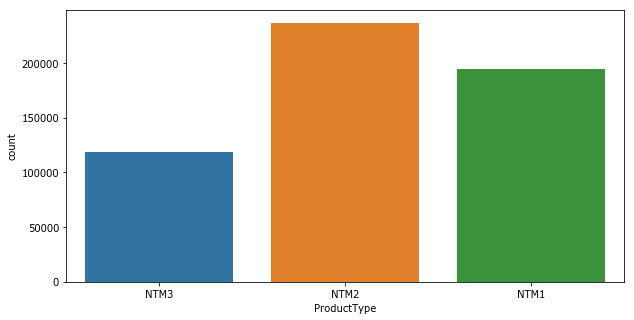

In [176]:
display_countplot(df, 'ProductType')

All 3 product types have significant contribution in the orders with NTM2 dominating and NTM3 with least number of rows

In [177]:
display_proportional_count(df, 'Manufacturer')

              per_contri
Manufacturer            
X1                 76.31
X2                 21.94
X3                  1.75


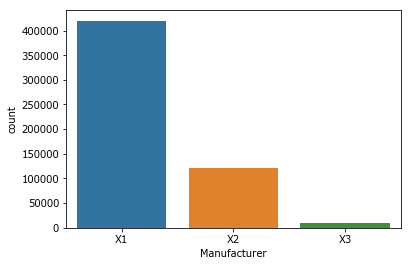

In [71]:
display_countplot(df, 'Manufacturer')

X1 has the highest percentage contribution as a manufacturer with more than 75% share, after that X2 has more than 20% share and X3 has less than 2% share

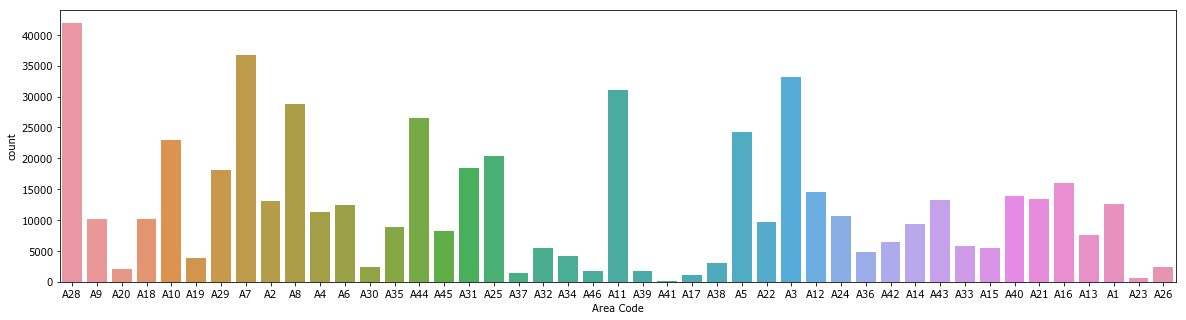

In [76]:
plt.rcParams["figure.figsize"] = (20,5)
display_countplot(df, 'Area Code')

There's a lot of variation in number of orders wrt area code

In [77]:
display_proportional_count(df, 'Sourcing Channel')

                  per_contri
Sourcing Channel            
DIRECT                 82.45
ECOM                    5.65
RETAIL                 10.91
WHOLESALE               0.99


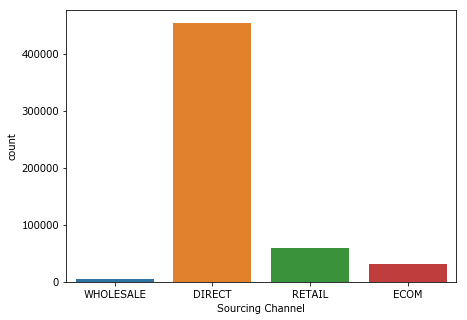

In [79]:
plt.rcParams["figure.figsize"] = (7,5)
display_countplot(df, 'Sourcing Channel')

Whoesale has a very less contribution in the train set (< 1%), Sourcing channel is dominated by "Direct"

In [81]:
display_proportional_count(df, 'Product Size')

              per_contri
Product Size            
ExtraLarge          0.75
Large              59.17
Small              40.07


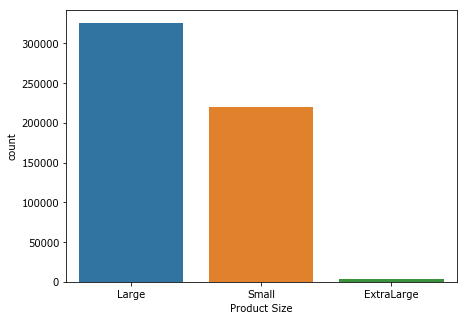

In [80]:
display_countplot(df, 'Product Size')

Small and Large dominate the "Product Size", XL has < 1% share

In [82]:
display_proportional_count(df, 'Product Type')

              per_contri
Product Type            
Liquid             14.28
Powder             85.72


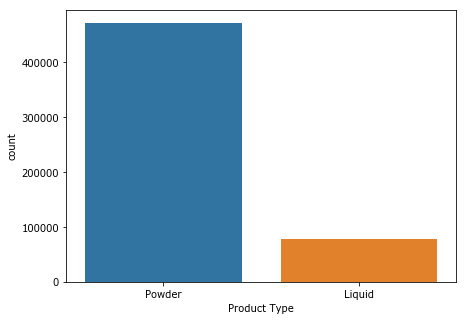

In [83]:
display_countplot(df, 'Product Type')

85% items have Product Type "Powder", rest 15% have "Liquid"

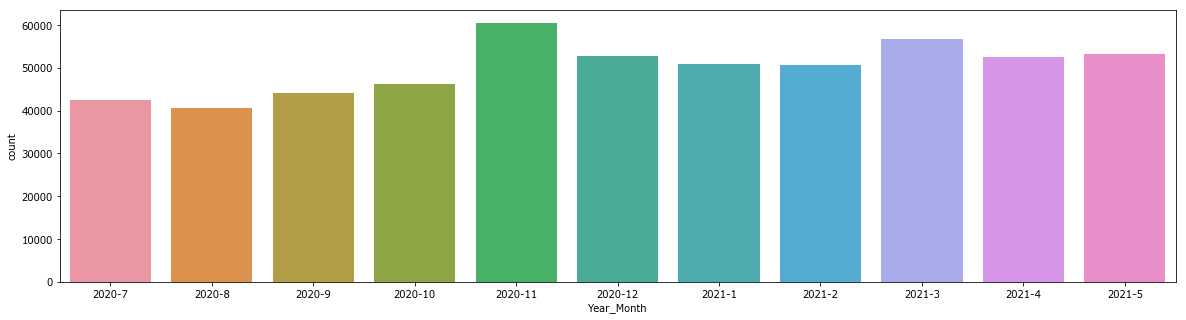

In [178]:
plt.rcParams["figure.figsize"] = (20,5)

df['Year_Month'] = df['Month of Sourcing'].dt.year.astype('str') + '-' + df['Month of Sourcing'].dt.month.astype('str')
order_list = [f'2020-{i}' for i in range(7, 13)] + [f'2021-{i}' for i in range(1, 6)]
display_countplot(
    df,
    'Year_Month',
    order=True,
    order_list=order_list
)

Number of order per month were highest in November 2020 and second highest in March 2021

In [112]:
dfg['Sourcing Cost'].describe()

count     9011.000000
mean       130.662686
std        527.894832
min       -196.070000
25%         43.729000
50%         97.897000
75%        142.635500
max      32632.500000
Name: Sourcing Cost, dtype: float64

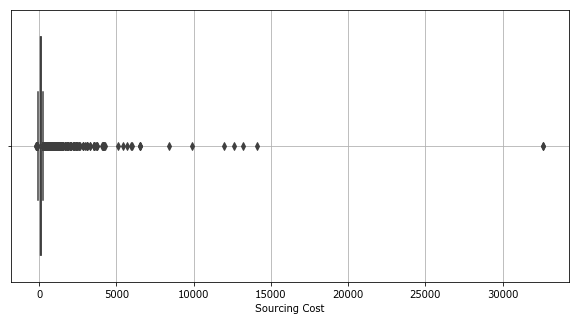

In [111]:
plt.rcParams["figure.figsize"] = (10,5)
display_box_plot(df, 'Sourcing Cost')

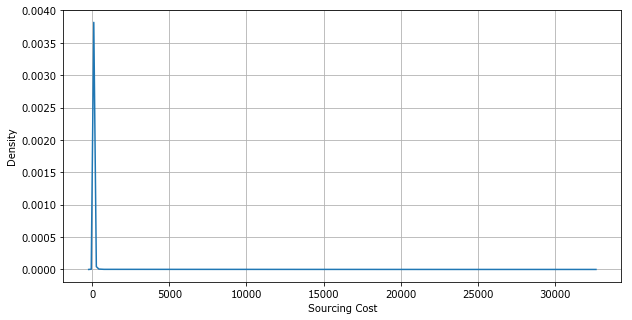

In [110]:
display_kde_plot(df, 'Sourcing Cost')

Sourcing Cost has significant outliers on the right side, also it has -ve values which doesn't make sense

In [117]:
for p in [0, 1, 2, 3, 4, 5, 90, 95, 96, 97, 98, 99, 99.5, 99.9]:
    print(f"{p}th percentile = {np.percentile(dfg['Sourcing Cost'], p).round(2)}")

0th percentile = -196.07
1th percentile = -0.0
2th percentile = -0.0
3th percentile = -0.0
4th percentile = -0.0
5th percentile = 0.0
90th percentile = 169.56
95th percentile = 212.98
96th percentile = 218.64
97th percentile = 282.6
98th percentile = 470.69
99th percentile = 919.38
99.5th percentile = 1804.75
99.9th percentile = 6041.03


### Capping the price for further analysis and modelling

In [13]:
df['Sourcing Cost'] = np.clip(df['Sourcing Cost'], 0, 500)

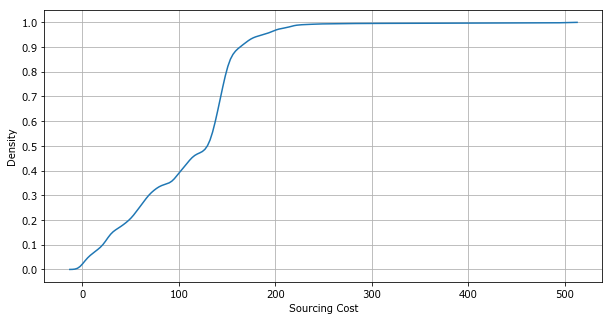

In [124]:
display_cdf_plot(df, 'Sourcing Cost')

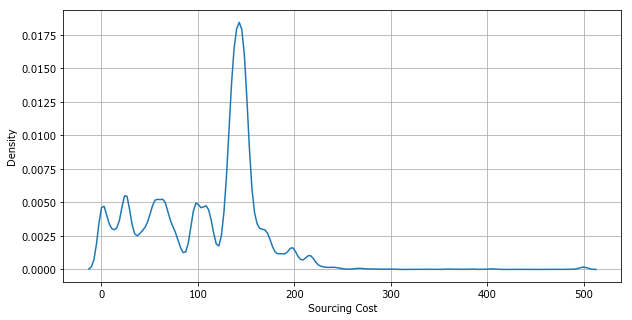

In [125]:
display_kde_plot(df, 'Sourcing Cost')

### 2.2.3 Bivariate Analysis

In [138]:
def display_agg_price(data, column):
    print(data.groupby(column).agg(
            {'Sourcing Cost' : 'mean'}
           ).round(2).reset_index().rename(columns={'Sourcing Cost' : 'Avg Sourcing Cost'})
          )

In [139]:
display_agg_price(df, 'ProductType')

  ProductType  Avg Sourcing Cost
0        NTM1             115.24
1        NTM2             121.31
2        NTM3              68.77


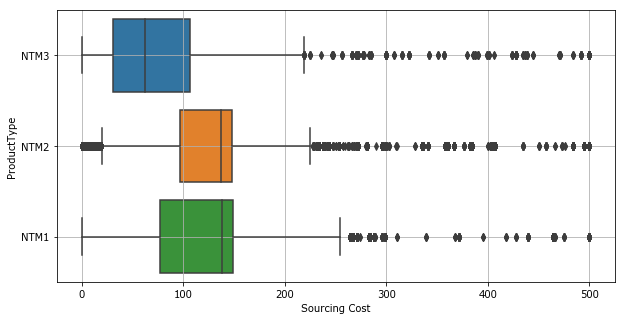

In [131]:
display_box_plot_2d(df, 'Sourcing Cost', 'ProductType',)

Sourcing cost for NTM3 Product is significantly lower than the other two, hence ProductType seems an important feature

In [140]:
display_agg_price(df, 'Manufacturer')

  Manufacturer  Avg Sourcing Cost
0           X1             120.56
1           X2              68.19
2           X3              49.89


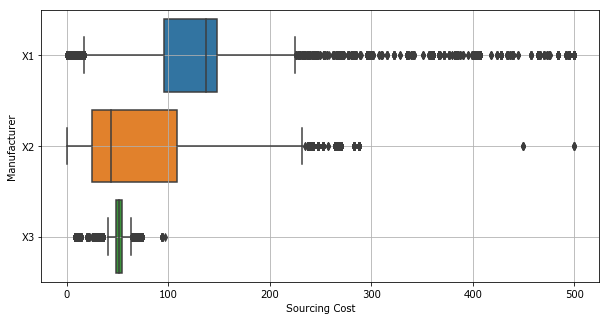

In [141]:
display_box_plot_2d(df, 'Sourcing Cost', 'Manufacturer')

Sourcing cost for Manufacturer X1 is significantly higher than that for X2, hence this seems an imp feature

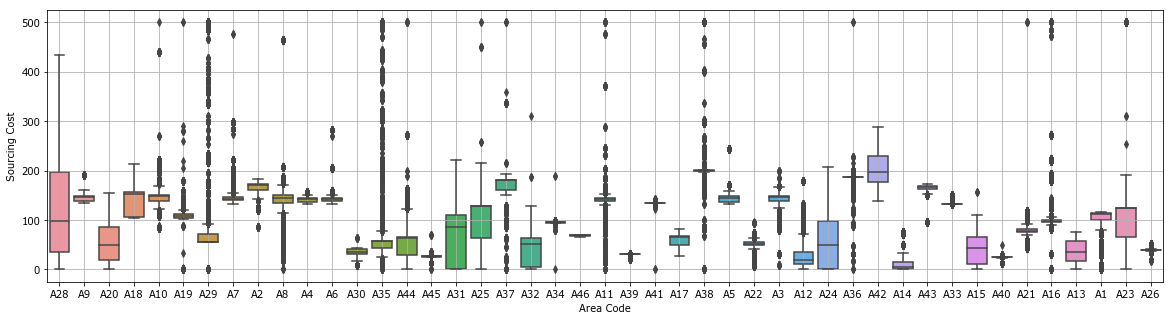

In [148]:
plt.rcParams["figure.figsize"] = (20,5)
display_box_plot_2d(df, 'Area Code', 'Sourcing Cost', orient='v')

There seems to be a lot of variation in Sourcing cost across areas, hence this seems an imp feature

In [149]:
display_agg_price(df, 'Sourcing Channel')

  Sourcing Channel  Avg Sourcing Cost
0           DIRECT             109.31
1             ECOM             144.73
2           RETAIL              79.65
3        WHOLESALE              84.94


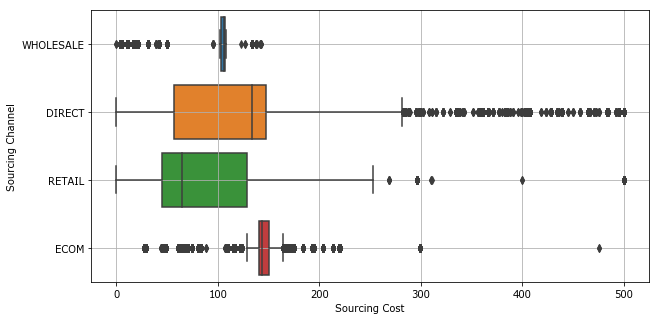

In [150]:
plt.rcParams["figure.figsize"] = (10,5)
display_box_plot_2d(df, 'Sourcing Cost', 'Sourcing Channel')

Sourcing cost of ECOMM is significantly higher than that of Direct which is significantly higher than that of RETAIL, significant variation across "Sourcing channel" indicates this is an important feature

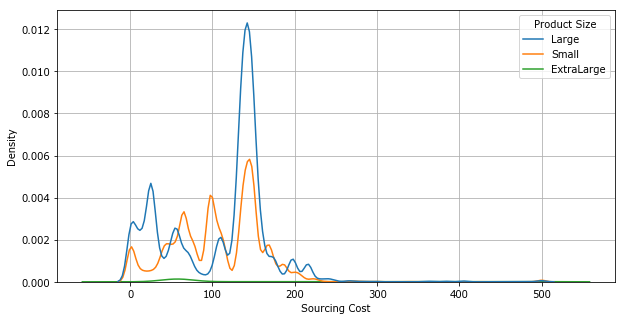

In [153]:
display_kde_plot_with_hue(df, 'Sourcing Cost', 'Product Size')

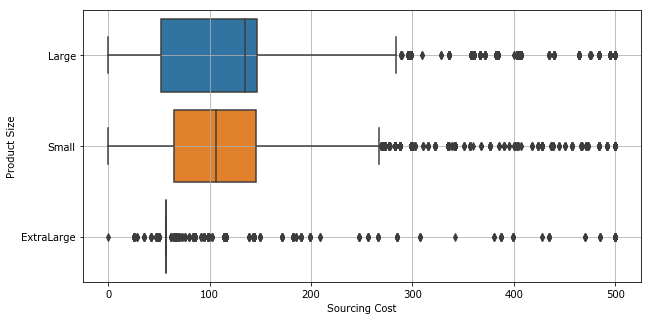

In [152]:
display_box_plot_2d(df, 'Sourcing Cost', 'Product Size')

In [151]:
display_agg_price(df, 'Product Size')

  Product Size  Avg Sourcing Cost
0   ExtraLarge              89.74
1        Large             108.70
2        Small             106.90


The KDE/Box plots are almost overlapping for Small/Large product sizes and hence this does not seem to be an important feature

In [155]:
display_agg_price(df, 'Product Type')

  Product Type  Avg Sourcing Cost
0       Liquid              89.34
1       Powder             110.92


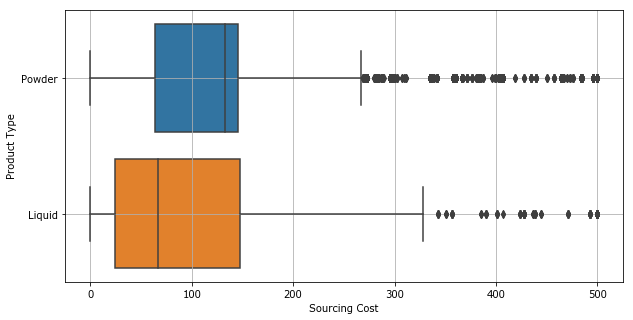

In [154]:
display_box_plot_2d(df, 'Sourcing Cost', 'Product Type')

Sourcing cost for "powder" is on a higher side as compared to "liquid", this seems an imp feature

In [156]:
display_agg_price(df, 'Month of Sourcing')

   Month of Sourcing  Avg Sourcing Cost
0         2020-07-01             101.02
1         2020-08-01              99.10
2         2020-09-01              95.00
3         2020-10-01              96.88
4         2020-11-01             106.53
5         2020-12-01             112.16
6         2021-01-01             111.12
7         2021-02-01             118.15
8         2021-03-01             118.59
9         2021-04-01             111.11
10        2021-05-01             109.69


There's not much variation in Sourcing Cost across different months, hence does not seem an important feature

# 3. Preprocessing / Feature Engineering


## 3.1 Train CV split

Since this is time series data, we'll do time based splitting instead of random splitting, we're keeping first 10 months of data as train data and last 1 month of data as CV data

In [117]:
df_train = df.loc[df['Month of Sourcing'] < '2021-05-01']
df_cv = df.loc[df['Month of Sourcing'] == '2021-05-01']

In [118]:
df_train['Month of Sourcing'].value_counts().sort_index()

2020-07-01    42469
2020-08-01    40640
2020-09-01    43995
2020-10-01    46215
2020-11-01    60446
2020-12-01    52752
2021-01-01    50844
2021-02-01    50562
2021-03-01    56643
2021-04-01    52438
Name: Month of Sourcing, dtype: int64

In [119]:
df_cv['Month of Sourcing'].value_counts().sort_index()

2021-05-01    53172
Name: Month of Sourcing, dtype: int64

## 3.2 Average price feature

For a given product (combination of columns A-F), we can compute the average Sourcing price for that product for each month and then use this as a feature <br>
For each month, we can use the prev. k months average sourcing price as features <br>
We can decide "k" by hyperparameter tuning

In [120]:
df_train.drop(columns=['index'], inplace=True)

In [121]:
df_train['avg_monthly_price'] = df_train.groupby(
    [ 'ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel',
      'Product Size', 'Product Type', 'Month of Sourcing'
    ]
)['Sourcing Cost'].transform('mean')
df_train.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,avg_monthly_price
1,NTM2,X1,A9,DIRECT,Large,Powder,2020-10-01,134.281,135.185763
2,NTM3,X2,A20,DIRECT,Large,Powder,2020-12-01,12.456,30.089574
3,NTM3,X1,A18,WHOLESALE,Small,Powder,2021-02-01,107.220,106.894342
4,NTM2,X1,A28,DIRECT,Large,Liquid,2020-11-01,197.763,195.963118
5,NTM1,X1,A10,DIRECT,Large,Powder,2020-09-01,137.932,138.310950


In [122]:
df_train = df_train.drop_duplicates()
df_cv = df_cv.drop_duplicates()

In [123]:
df_train.sort_values(by=['ProductType',	'Manufacturer',	'Area Code',
                          'Sourcing Channel', 'Product Size',
                          'Product Type', 'Month of Sourcing', 'Sourcing Cost'],
                     inplace=True
                     )

In [124]:
def get_prev_month_avg_cost(row, lag_months):
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Product Size']==row['Product Size']) & \
                    (df_train['Product Type']==row['Product Type']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing']-pd.DateOffset(months=lag_months))
                ]
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    return pd.NA 

In [125]:
df_train['avg_monthly_price_lag_1'] = df_train.apply(
    get_prev_month_avg_cost, lag_months=1, axis=1
)

df_train['avg_monthly_price_lag_2'] = df_train.apply(
    get_prev_month_avg_cost, lag_months=2, axis=1
)

df_train['avg_monthly_price_lag_3'] = df_train.apply(
    get_prev_month_avg_cost, lag_months=3, axis=1
)

In [126]:
df_train.isna().sum()

ProductType                   0
Manufacturer                  0
Area Code                     0
Sourcing Channel              0
Product Size                  0
Product Type                  0
Month of Sourcing             0
Sourcing Cost                 0
avg_monthly_price             0
avg_monthly_price_lag_1     847
avg_monthly_price_lag_2    1641
avg_monthly_price_lag_3    2386
dtype: int64

There are nulls in lag feature due to 2 reasons:
1. The row is from the first month of observation (july 20) in case of nulls in avg_monthly_price_lag_1 or from first/second month of obs. (july/aug 20) in case of nulls in avg_monthly_price_lag_2 or from first/second/third month of obs. (july/aug/sep 20) in case of nulls in 
avg_monthly_price_lag_3

2. The exact given product combination (A-F) did not exist in the previous month

Nulls occurring due to (1) are to be handled only at train time, as during test time, we have data from previous 3 months, these can be handled by backfilling, for eg. if avg_monthly_price_lag_1 is null for July-20, for a particular product combination, we impute it with the avg_monthly_price_lag_1 value of the same product combination of Aug-20, again, if avg_monthly_price_lag_2 is null for July-20, for a particular product combination, we impute it with the avg_monthly_price_lag_2 value of the same product combination of Sep-20 (because Aug-20 value of avg_monthly_price_lag_2 is null) and so on

Nulls occurring due to (2) can occur also at test time as the exact same product combination might not be present in the prev month(s) data, in this case, we'll use some of the columns from (A-F) so that the corresponding data is more likely to be present in previous month(s)

#### Imputing train time nulls by bfill

In [127]:
def fill_nans_by_bfill(row, lag_months, lagged_month_feat):
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Product Size']==row['Product Size']) & \
                    (df_train['Product Type']==row['Product Type']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] + pd.DateOffset(months=lag_months))
                ]
    if sampled_df.shape[0] > 0:
        return sampled_df[f'avg_monthly_price_lag_{lagged_month_feat}'].iloc[0]
    
    return pd.NA 

In [128]:
df_train.loc[
    (df_train['Month of Sourcing']=='2020-07-01') & (df_train.avg_monthly_price_lag_1.isnull()),
    'avg_monthly_price_lag_1'
] = df_train.loc[
        (df_train['Month of Sourcing']=='2020-07-01') & (df_train.avg_monthly_price_lag_1.isnull())
    ].apply(fill_nans_by_bfill, lag_months=1, lagged_month_feat=1, axis=1)

df_train.loc[
    (df_train['Month of Sourcing']=='2020-07-01') & (df_train.avg_monthly_price_lag_2.isnull()),
    'avg_monthly_price_lag_2'
] = df_train.loc[
        (df_train['Month of Sourcing']=='2020-07-01') & (df_train.avg_monthly_price_lag_2.isnull())
    ].apply(fill_nans_by_bfill, lag_months=2, lagged_month_feat=2, axis=1)

df_train.loc[
    (df_train['Month of Sourcing']=='2020-07-01') & (df_train.avg_monthly_price_lag_3.isnull()),
    'avg_monthly_price_lag_3'
] = df_train.loc[
        (df_train['Month of Sourcing']=='2020-07-01') & (df_train.avg_monthly_price_lag_3.isnull())
    ].apply(fill_nans_by_bfill, lag_months=3, lagged_month_feat=3, axis=1)

df_train.loc[
    (df_train['Month of Sourcing']=='2020-08-01') & (df_train.avg_monthly_price_lag_2.isnull()),
    'avg_monthly_price_lag_2'
] = df_train.loc[
        (df_train['Month of Sourcing']=='2020-08-01') & (df_train.avg_monthly_price_lag_2.isnull())
    ].apply(fill_nans_by_bfill, lag_months=1, lagged_month_feat=2, axis=1)

df_train.loc[
    (df_train['Month of Sourcing']=='2020-08-01') & (df_train.avg_monthly_price_lag_3.isnull()),
    'avg_monthly_price_lag_3'
] = df_train.loc[
        (df_train['Month of Sourcing']=='2020-08-01') & (df_train.avg_monthly_price_lag_3.isnull())
    ].apply(fill_nans_by_bfill, lag_months=2, lagged_month_feat=3, axis=1)

df_train.loc[
    (df_train['Month of Sourcing']=='2020-09-01') & (df_train.avg_monthly_price_lag_3.isnull()),
    'avg_monthly_price_lag_3'
] = df_train.loc[
        (df_train['Month of Sourcing']=='2020-09-01') & (df_train.avg_monthly_price_lag_3.isnull())
    ].apply(fill_nans_by_bfill, lag_months=1, lagged_month_feat=3, axis=1)

In [129]:
df_train.isna().sum()

ProductType                 0
Manufacturer                0
Area Code                   0
Sourcing Channel            0
Product Size                0
Product Type                0
Month of Sourcing           0
Sourcing Cost               0
avg_monthly_price           0
avg_monthly_price_lag_1    12
avg_monthly_price_lag_2    40
avg_monthly_price_lag_3    67
dtype: int64

Now these nulls are present due to the same product (A-F) not being present in the previous month, we'll impute these using a more generalized product which consists of only some of the columns from A-F

In [130]:
def fill_nans_test_time(row, lag_months):
    # Exclude product size as it has the least impact on sourcing cost
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Product Type']==row['Product Type']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Product Type
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Sourcing Channel
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Manufacturer
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude ProductType
    sampled_df = df_train[
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    return pd.NA 

In [131]:
df_train.loc[
    df_train.avg_monthly_price_lag_1.isnull(),
    'avg_monthly_price_lag_1'
] = df_train.loc[
        df_train.avg_monthly_price_lag_1.isnull()
    ].apply(fill_nans_test_time, lag_months=1, axis=1)

df_train.loc[
    df_train.avg_monthly_price_lag_2.isnull(),
    'avg_monthly_price_lag_2'
] = df_train.loc[
        df_train.avg_monthly_price_lag_2.isnull()
    ].apply(fill_nans_test_time, lag_months=2, axis=1)

df_train.loc[
    df_train.avg_monthly_price_lag_3.isnull(),
    'avg_monthly_price_lag_3'
] = df_train.loc[
        df_train.avg_monthly_price_lag_3.isnull()
    ].apply(fill_nans_test_time, lag_months=3, axis=1)

In [132]:
df_train.isna().sum()

ProductType                 0
Manufacturer                0
Area Code                   0
Sourcing Channel            0
Product Size                0
Product Type                0
Month of Sourcing           0
Sourcing Cost               0
avg_monthly_price           0
avg_monthly_price_lag_1     0
avg_monthly_price_lag_2     0
avg_monthly_price_lag_3    19
dtype: int64

In [133]:
df_train[df_train.avg_monthly_price_lag_3.isna()]

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,avg_monthly_price,avg_monthly_price_lag_1,avg_monthly_price_lag_2,avg_monthly_price_lag_3
63129,NTM3,X1,A10,ECOM,Large,Powder,2020-07-01,88.400,109.746667,109.746667,109.746667,<NA>
59484,NTM3,X1,A10,ECOM,Large,Powder,2020-07-01,130.280,109.746667,109.746667,109.746667,<NA>
42391,NTM3,X1,A10,ECOM,Large,Powder,2020-07-01,131.500,109.746667,109.746667,109.746667,<NA>
79073,NTM3,X1,A10,ECOM,Large,Powder,2020-08-01,131.795,132.566308,109.746667,109.746667,<NA>
5731,NTM3,X1,A10,ECOM,Large,Powder,2020-08-01,132.509,132.566308,109.746667,109.746667,<NA>
106739,NTM3,X1,A10,ECOM,Large,Powder,2020-08-01,133.175,132.566308,109.746667,109.746667,<NA>
124726,NTM3,X1,A10,ECOM,Large,Powder,2020-08-01,133.350,132.566308,109.746667,109.746667,<NA>
13373,NTM3,X1,A10,ECOM,Large,Powder,2020-09-01,107.404,120.482800,132.566308,109.746667,<NA>
132413,NTM3,X1,A10,ECOM,Large,Powder,2020-09-01,131.680,120.482800,132.566308,109.746667,<NA>
6987,NTM3,X1,A10,ECOM,Large,Powder,2020-09-01,134.032,120.482800,132.566308,109.746667,<NA>


These are NAs which got missed at train time, we can impute them with lag_2 features as they're anyways very less in number

In [134]:
df_train.loc[df_train.avg_monthly_price_lag_3.isna(), 'avg_monthly_price_lag_3'] = \
      df_train.loc[df_train.avg_monthly_price_lag_3.isna(), 'avg_monthly_price_lag_2']

In [135]:
df_train.isna().sum()

ProductType                0
Manufacturer               0
Area Code                  0
Sourcing Channel           0
Product Size               0
Product Type               0
Month of Sourcing          0
Sourcing Cost              0
avg_monthly_price          0
avg_monthly_price_lag_1    0
avg_monthly_price_lag_2    0
avg_monthly_price_lag_3    0
dtype: int64

In [156]:
def get_prev_month_avg_cost(row, lag_months):
    # Include all columns A-F
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Product Size']==row['Product Size']) & \
                    (df_train['Product Type']==row['Product Type']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing']-pd.DateOffset(months=lag_months))
                ]
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude product size as it has the least impact on sourcing cost
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Product Type']==row['Product Type']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Product Type
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Sourcing Channel
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Manufacturer']==row['Manufacturer']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Manufacturer
    sampled_df = df_train[
                    (df_train['ProductType']==row['ProductType']) & \
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude ProductType
    sampled_df = df_train[
                    (df_train['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    return pd.NA 

In [138]:
df_cv.drop(columns=['index'], inplace=True)

In [154]:
df_cv['avg_monthly_price_lag_1'] = df_cv.apply(
    get_prev_month_avg_cost, lag_months=1, axis=1
)
print("lag 1 features computed")

df_cv['avg_monthly_price_lag_2'] = df_cv.apply(
    get_prev_month_avg_cost, lag_months=2, axis=1
)
print("lag 2 features computed")

df_cv['avg_monthly_price_lag_3'] = df_cv.apply(
    get_prev_month_avg_cost, lag_months=3, axis=1
)
print("lag 3 features computed")

lag 1 features computed
lag 2 features computed
lag 3 features computed


In [158]:
df_cv.isna().sum()

ProductType                0
Manufacturer               0
Area Code                  0
Sourcing Channel           0
Product Size               0
Product Type               0
Month of Sourcing          0
Sourcing Cost              0
avg_monthly_price_lag_1    0
avg_monthly_price_lag_2    0
avg_monthly_price_lag_3    0
dtype: int64

In [173]:
df_train.to_csv('df_train.csv', index=False)
df_cv.to_csv('df_cv.csv', index=False)

## 3.3 One Hot Encoding

In [287]:
ohes = []
ohe_features_train = []
ohe_features_cv = []

for col in df_train.columns[:6]:
    enc = OneHotEncoder()
    enc.fit(np.asarray(df_train[col]).reshape(-1, 1))
    ohe_features_train.append(enc.transform(np.asarray(df_train[col]).reshape(-1, 1)))
    ohe_features_cv.append(enc.transform(np.asarray(df_cv[col]).reshape(-1, 1)))
    ohes.append(enc)

## 3.4 Standard Scaling

In [288]:
scalers = []
scaled_features_train = []
scaled_features_cv = []

for col in ['avg_monthly_price_lag_1', 'avg_monthly_price_lag_2', 'avg_monthly_price_lag_3']:
    scal = StandardScaler()
    scal.fit(np.asarray(df_train[col]).reshape(-1, 1))
    scaled_features_train.append(scal.transform(np.asarray(df_train[col]).reshape(-1, 1)))
    scaled_features_cv.append(scal.transform(np.asarray(df_cv[col]).reshape(-1, 1)))
    scalers.append(scal)

## 3.5 Combining the features

In [178]:
X_tr = hstack(
    (
        ohe_features_train[0], ohe_features_train[1], ohe_features_train[2],
        ohe_features_train[3], ohe_features_train[4], ohe_features_train[5],
        scaled_features_train[0], scaled_features_train[1], scaled_features_train[2]
    )
)

X_cv = hstack(
    (
        ohe_features_cv[0], ohe_features_cv[1], ohe_features_cv[2],
        ohe_features_cv[3], ohe_features_cv[4], ohe_features_cv[5],
        scaled_features_cv[0], scaled_features_cv[1], scaled_features_cv[2]
    )
)

In [179]:
print(X_tr.shape)
print(X_cv.shape)

(7806, 63)
(709, 63)


## 3.6 Creating y-label

In [190]:
y_train = df_train['Sourcing Cost'].reset_index(drop=True)
y_cv = df_cv['Sourcing Cost'].reset_index(drop=True)

# 4. Selecting performance metric

RMSE seems a good performance metric as it's a regression setting

In [199]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)).round(2)

# 5. Modelling

## 5.1 Baseline model (mean model)

In [200]:
y_pred_train = [y_train.mean()]*y_train.shape[0]
y_pred_cv = [y_train.mean()]*y_cv.shape[0]
print(f"Train RMSE = {rmse(y_train, y_pred_train)}")
print(f"CV RMSE = {rmse(y_cv, y_pred_cv)}")

Train RMSE = 74.31
CV RMSE = 67.85


## 5.2 Linear Regression

In [202]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_tr, y_train)
y_pred_train = lr.predict(X_tr)
y_pred_cv = lr.predict(X_cv)
print(f"Train RMSE = {rmse(y_train, y_pred_train)}")
print(f"CV RMSE = {rmse(y_cv, y_pred_cv)}")

Train RMSE = 53.67
CV RMSE = 54.59


## 5.3 Ridge regression (with HP tuning)

In [204]:
for alpha in [10**x for x in range(-3, 4)]:
    lr = Ridge(alpha=alpha)
    lr.fit(X_tr, y_train)
    y_pred_train = lr.predict(X_tr)
    y_pred_cv = lr.predict(X_cv)
    print(f"alpha = {alpha}")
    print(f"Train RMSE = {rmse(y_train, y_pred_train)}")
    print(f"CV RMSE = {rmse(y_cv, y_pred_cv)}")
    print()

alpha = 0.001
Train RMSE = 53.67
CV RMSE = 54.6

alpha = 0.01
Train RMSE = 53.67
CV RMSE = 54.6

alpha = 0.1
Train RMSE = 53.67
CV RMSE = 54.59

alpha = 1
Train RMSE = 53.68
CV RMSE = 54.58

alpha = 10
Train RMSE = 53.86
CV RMSE = 54.5

alpha = 100
Train RMSE = 56.3
CV RMSE = 55.42

alpha = 1000
Train RMSE = 61.38
CV RMSE = 57.41



Linear Regression (even with HP tuning seems to be underfitting which is expected since linear models have high bias)

## 5.4 Boosting (LGBM)

In [224]:
lgbm_model = lgbm.LGBMRegressor(random_state=21, n_jobs=-1)
lgbm_model.fit(X_tr, y_train)
y_pred_train = lgbm_model.predict(X_tr)
y_pred_cv = lgbm_model.predict(X_cv)
print(f"Train RMSE = {rmse(y_train, y_pred_train)}")
print(f"CV RMSE = {rmse(y_cv, y_pred_cv)}")

Train RMSE = 48.04
CV RMSE = 54.22


In [217]:
X_tr_df = pd.DataFrame(X_tr.toarray())
X_cv_df = pd.DataFrame(X_cv.toarray())
X_df = pd.concat([X_tr_df, X_cv_df]).reset_index(drop=True)
y_df = pd.concat([y_train, y_cv]).reset_index(drop=True)

In [227]:
parameters = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [1,3,5,7],
    'learning_rate' : [0.025, 0.05, 0.1, 0.2],
    'subsample' : [0.2, 0.4, 0.6, 0.8, 1],
    'colsample_bytree' : [0.2, 0.4, 0.6, 0.8, 1],
}
lgbm_model = lgbm.LGBMRegressor(random_state=21, n_jobs=-1)

In [228]:
split_index = [-1]*X_tr_df.shape[0] + [0]*X_cv_df.shape[0]
pds = PredefinedSplit(test_fold = split_index)
clf = GridSearchCV(estimator = lgbm_model,
                   cv=pds,
                   param_grid=parameters,
                   scoring='neg_root_mean_squared_error',
                   n_jobs=-1)

# Fit with all data
clf.fit(X_df, y_df)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LGBMRegressor(random_state=21), n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
                         'learning_rate': [0.025, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'subsample': [0.2, 0.4, 0.6, 0.8, 1]},
             scoring='neg_root_mean_squared_error')

In [235]:
clf.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'subsample': 0.2}

In [236]:
lgbm_model = lgbm.LGBMRegressor(
    colsample_bytree=0.2,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.2,
    random_state=21,
    n_jobs=-1
)
lgbm_model.fit(X_tr, y_train)
y_pred_train = lgbm_model.predict(X_tr)
y_pred_cv = lgbm_model.predict(X_cv)
print(f"Train RMSE = {rmse(y_train, y_pred_train)}")
print(f"CV RMSE = {rmse(y_cv, y_pred_cv)}")

Train RMSE = 49.05
CV RMSE = 51.05


## 5.5 Training the final model

LGBM with hyperaparameter tuning gives the best results and hence we choose it as our final model

In [243]:
lgbm_model = lgbm.LGBMRegressor(
    colsample_bytree=0.2,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.2,
    random_state=21,
    n_jobs=-1
)
lgbm_model.fit(X_df, y_df)

LGBMRegressor(colsample_bytree=0.2, max_depth=7, n_estimators=200,
              random_state=21, subsample=0.2)

## 5.6 Preprocessing the test set

In [277]:
df_test = pd.read_excel('DS_ML Coding Challenge Dataset.xlsx', sheet_name=2)
df_test['Month of Sourcing'] = df_test['Month of Sourcing'] - pd.DateOffset(days=20)

In [247]:
df_cv['avg_monthly_price'] = df_cv.groupby(
    [ 'ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel',
      'Product Size', 'Product Type', 'Month of Sourcing'
    ]
)['Sourcing Cost'].transform('mean')
df_cv.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,avg_monthly_price_lag_1,avg_monthly_price_lag_2,avg_monthly_price_lag_3,avg_monthly_price
0,NTM3,X1,A28,WHOLESALE,Large,Powder,2021-05-01,10.158,14.74986,37.074920,80.170400,58.760000
45,NTM2,X1,A9,DIRECT,Large,Powder,2021-05-01,148.396,75.837137,146.268369,116.629300,148.076800
49,NTM1,X2,A30,RETAIL,Small,Powder,2021-05-01,41.040,25.17789,28.244732,30.140524,30.369000
50,NTM1,X1,A10,DIRECT,Large,Powder,2021-05-01,156.789,152.542206,148.601538,169.954570,153.326857
54,NTM1,X1,A2,ECOM,Small,Powder,2021-05-01,174.828,173.269936,171.757087,174.769755,174.828000


In [252]:
train_avg_mnthly_price = df_train['avg_monthly_price']
df_train.drop(columns=['avg_monthly_price'], inplace=True)
df_train['avg_monthly_price'] = train_avg_mnthly_price
df_train.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,avg_monthly_price_lag_1,avg_monthly_price_lag_2,avg_monthly_price_lag_3,avg_monthly_price
0,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,82.428,108.093218,108.093218,108.093218,108.093218
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,89.489,108.093218,108.093218,108.093218,108.093218
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,95.089,108.093218,108.093218,108.093218,108.093218
3,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,100.372,108.093218,108.093218,108.093218,108.093218
4,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,104.454,108.093218,108.093218,108.093218,108.093218


In [254]:
df = pd.concat([df_train, df_cv])
df.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,avg_monthly_price_lag_1,avg_monthly_price_lag_2,avg_monthly_price_lag_3,avg_monthly_price
0,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,82.428,108.093218,108.093218,108.093218,108.093218
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,89.489,108.093218,108.093218,108.093218,108.093218
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,95.089,108.093218,108.093218,108.093218,108.093218
3,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,100.372,108.093218,108.093218,108.093218,108.093218
4,NTM1,X1,A1,DIRECT,Small,Powder,2020-07-01,104.454,108.093218,108.093218,108.093218,108.093218


In [266]:
df['Month of Sourcing'] = pd.to_datetime(df['Month of Sourcing'])

In [267]:
def get_prev_month_avg_cost(row, lag_months):
    # Include all columns A-F
    sampled_df = df[
                    (df['ProductType']==row['ProductType']) & \
                    (df['Manufacturer']==row['Manufacturer']) & \
                    (df['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df['Product Size']==row['Product Size']) & \
                    (df['Product Type']==row['Product Type']) & \
                    (df['Month of Sourcing'] == row['Month of Sourcing']-pd.DateOffset(months=lag_months))
                ]
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude product size as it has the least impact on sourcing cost
    sampled_df = df[
                    (df['ProductType']==row['ProductType']) & \
                    (df['Manufacturer']==row['Manufacturer']) & \
                    (df['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df['Product Type']==row['Product Type']) & \
                    (df['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Product Type
    sampled_df = df[
                    (df['ProductType']==row['ProductType']) & \
                    (df['Manufacturer']==row['Manufacturer']) & \
                    (df['Sourcing Channel']==row['Sourcing Channel']) & \
                    (df['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Sourcing Channel
    sampled_df = df[
                    (df['ProductType']==row['ProductType']) & \
                    (df['Manufacturer']==row['Manufacturer']) & \
                    (df['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude Manufacturer
    sampled_df = df[
                    (df['ProductType']==row['ProductType']) & \
                    (df['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    # Exclude ProductType
    sampled_df = df[
                    (df['Month of Sourcing'] == row['Month of Sourcing'] - pd.DateOffset(months=lag_months))
                ]
    
    if sampled_df.shape[0] > 0:
        return sampled_df['avg_monthly_price'].iloc[0]
    
    return pd.NA 

In [283]:
df_test['avg_monthly_price_lag_1'] = df_test.apply(
    get_prev_month_avg_cost, lag_months=1, axis=1
)

df_test['avg_monthly_price_lag_2'] = df_test.apply(
    get_prev_month_avg_cost, lag_months=2, axis=1
)

df_test['avg_monthly_price_lag_3'] = df_test.apply(
    get_prev_month_avg_cost, lag_months=3, axis=1
)

In [290]:
ohe_features_test = []
for idx, ohe in enumerate(ohes):
    ohe_features_test.append(
        ohe.transform(np.asarray(df_test.iloc[:, idx]).reshape(-1, 1))
    )

In [292]:
scaled_features_test = []
for idx, scal in enumerate(scalers, start=8):
    scaled_features_test.append(
        scal.transform(np.asarray(df_test.iloc[:, idx]).reshape(-1, 1))
    )

In [298]:
X_te = hstack((
    ohe_features_test[0], ohe_features_test[1], ohe_features_test[2],
    ohe_features_test[3], ohe_features_test[4], ohe_features_test[5],
    scaled_features_test[0], scaled_features_test[1], scaled_features_test[2]
))

In [300]:
y_test = df_test['Sourcing Cost'].reset_index(drop=True)

## 5.7 Final Predictions

In [301]:
y_test_pred = lgbm_model.predict(X_te)
print(f"Test RMSE = {rmse(y_test, y_test_pred)}")

Test RMSE = 38.38


In [303]:
df_test.drop(
    columns=['avg_monthly_price_lag_1', 'avg_monthly_price_lag_2', 'avg_monthly_price_lag_3'],
    inplace=True
)

In [306]:
df_test['Predicted Sourcing Cost'] = y_test_pred.round(2)
df_test.to_excel('df_test_pred.xlsx', index=False)